# COVID19 Timeseries Data Viz
## Re-create The Financial Times coronavirus graphs in R
This tutorial was developed for visualizing the COVID19 timeseries data. The tutorial has two parts, in the first part we will reproduce a similar visualisation of cumulative deaths to one of [@John Burn-Murdoch](https://twitter.com/jburnmurdoch)'s most classic charts for [@FinancialTimes](https://twitter.com/FinancialTimes). While in the second part, we are going to reproduce one of his most famous coronavirus trajectory trackers .

#### Original plot of cumulative deaths on Financial Times
![Oroginal plot of cumulative deaths on Financial Times](FT_JohnBurnMurdoch.jpeg)


#### Coronavirus trajectory tracker of subnational region daily deaths on Financial Times
![Oroginal plot of coronavirus trajectory tracker on Financial Times](FT_JohnBurnMurdoch2.jpeg)

## Importing R packages

In [1]:
# R Packages
library(magrittr) # for pipe operations like %>% and %<>%
library(lubridate) # for date operations
library(tidyverse) # collection of R packages for data science, including dplyr and tidyr for data processing and ggplot2 for graphics
#library(knitr)
library(formattable) # for formatting numerical values

Warning message:
“package ‘lubridate’ was built under R version 3.6.2”

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘tibble’ was built under R version 3.6.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ lubridate::date()        masks base::date()
✖ tidyr::extract()         masks magrittr::extract()
✖ dplyr::filter()          masks stats::filter()
✖ lubridate::intersect()   masks base::intersect()
✖ dplyr::lag()             masks stats::lag()
✖ purrr::set_names()       masks magrittr::set_names()
✖ lubridate::setdiff()     masks base::setdiff()
✖ lubridate::union()    

## Loading Data
We are going to use the latest timeseries data collated by Johns Hopkins University, which is available at JHU's Github repository 

(Source: [Johns Hopkins CSSEGISandData](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)).

In [2]:
# read in the latest timeseries data
data.deaths <- read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
data.deaths %>% head()


Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.



Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,⋯,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,⋯,42,43,47,50,57,58,60,64,68,72
NA,Albania,41.1533,20.1683,0,0,0,0,0,0,⋯,27,27,27,28,28,30,30,31,31,31
NA,Algeria,28.0339,1.6596,0,0,0,0,0,0,⋯,407,415,419,425,432,437,444,450,453,459
NA,Andorra,42.5063,1.5218,0,0,0,0,0,0,⋯,37,40,40,40,40,41,42,42,43,44
NA,Angola,-11.2027,17.8739,0,0,0,0,0,0,⋯,2,2,2,2,2,2,2,2,2,2
NA,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,⋯,3,3,3,3,3,3,3,3,3,3


Each dataset has 266 rows, corresponding to country/region/province/state. 

And has 105 columns. Starting from column 5, each column corresponds to a single day. Here we draw a random sample of 10 rows and have a look at their first 10 columns.

In [3]:
dim(data.deaths)

[1] 266 106

In [4]:
data.deaths[, 1:10] %>% sample_n(5) 

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,Slovenia,46.1512,14.9955,0,0,0,0,0,0
NA,Nigeria,9.0820,8.6753,0,0,0,0,0,0
NA,Malaysia,2.5000,112.5000,0,0,0,0,0,0
NA,Montenegro,42.5000,19.3000,0,0,0,0,0,0
Ningxia,China,37.2692,106.1655,0,0,0,0,0,0


We are removing the `Province/State` column and aggregate the data by `Country/Region` because our goal in this tutorial is to vusualise the covid trajectory at national level.

In [5]:
# drops province/state (sub-national level data)
data.deaths <- data.deaths %>% select(-c(`Province/State`,Lat,Long))
data.deaths %>% head()

Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,⋯,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,0,0,0,0,0,0,0,0,0,⋯,42,43,47,50,57,58,60,64,68,72
Albania,0,0,0,0,0,0,0,0,0,⋯,27,27,27,28,28,30,30,31,31,31
Algeria,0,0,0,0,0,0,0,0,0,⋯,407,415,419,425,432,437,444,450,453,459
Andorra,0,0,0,0,0,0,0,0,0,⋯,37,40,40,40,40,41,42,42,43,44
Angola,0,0,0,0,0,0,0,0,0,⋯,2,2,2,2,2,2,2,2,2,2
Antigua and Barbuda,0,0,0,0,0,0,0,0,0,⋯,3,3,3,3,3,3,3,3,3,3


In [6]:
# Below we check the time frame of the data
n.col <- ncol(data.deaths)
## get dates from column names
dates <- names(data.deaths)[2:n.col] %>% substr(1,7) %>% mdy()
range(dates)

[1] "2020-01-22" "2020-05-02"

## Data Preparation
### Data Cleaning
We will first convert the dataset from wide to long format, and then hace it aggregated by country.

In [7]:
## data cleaning and transformation
cleanData <- function(data) {
    ## convert from wide to long format
    data %<>% gather(key=date, value=count, c(-`Country/Region`))
    ## convert from character to date
    data %<>% mutate(date = date %>% substr(1,7) %>% mdy())
    ## aggregate by country
    data %<>% group_by(`Country/Region`, date) %>% summarise(count=sum(count)) %>% as.data.frame()
    return(data)
}

In [8]:
## clean data by calling the function we just defined
data.deaths %<>% cleanData() 
data.deaths <- data.deaths %>% drop_na()

In [9]:
# America when it first broke out in China
data.deaths %>% filter(grepl(".?(US)$", `Country/Region`)) %>% head(10)

,Country/Region,date,count
,<chr>,<date>,<dbl>
1,US,2020-01-22,0
2,US,2020-01-23,0
3,US,2020-01-24,0
4,US,2020-01-25,0
5,US,2020-01-26,0
6,US,2020-01-27,0
7,US,2020-01-28,0
8,US,2020-01-29,0
9,US,2020-01-30,0


In [10]:
# America today
data.deaths %>% filter(grepl(".?(US)$", `Country/Region`)) %>% tail(10)

,Country/Region,date,count
,<chr>,<date>,<dbl>
93,US,2020-04-23,49724
94,US,2020-04-24,51493
95,US,2020-04-25,53755
96,US,2020-04-26,54881
97,US,2020-04-27,56259
98,US,2020-04-28,58355
99,US,2020-04-29,60967
100,US,2020-04-30,62996
101,US,2020-05-01,64943


We can see that the US has overtaken China and Italy with most cases now.

In [11]:
data.deaths %>% filter(count==max(data.deaths$count))

Country/Region,date,count
<chr>,<date>,<dbl>
US,2020-05-02,66369


### Data Manipulation - Finding number of days since 10 death

Before we move on... Let's just rename the dataset first for simplicity from now on
(Typing and spelling is killing me).

In [12]:
data <- data.deaths %>% ungroup()

To calculate the number of days since 10th death for our x-axis, we need to first find out the date when 10th death happened in each country (if it did), we call it **"day1"** here.

We will define a function trying to find their `day1`'s.

In [13]:
# marking the first day having cumulative deaths passed 10
first_greater_than = function(x, value)
    ifelse((x >= value) & (cumsum(x >= value) == 1),1,0)

# run on the data 
data <- data %>% group_by(`Country/Region`) %>% mutate(day1=first_greater_than(count,10)) %>%
    mutate(new=cumsum(day1)) %>% mutate(since_day1=cumsum(new))

In [14]:
data %>% filter(`Country/Region`=='Italy',since_day1>0) %>% head()

Country/Region,date,count,day1,new,since_day1
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
Italy,2020-02-25,10,1,1,1
Italy,2020-02-26,12,0,1,2
Italy,2020-02-27,17,0,1,3
Italy,2020-02-28,21,0,1,4
Italy,2020-02-29,29,0,1,5
Italy,2020-03-01,34,0,1,6


## A subset of data
Now there are hundreds of nations in our dataset, so we need to specifically define what are the countries we want highlight in the chart. For this tutorial, we will pick just a few of them so the visualisation doesn't get too crowded and messy.

`c('US','Italy','United Kingdom','France','Spain','Australia','Canada','Japan','Korea, South','Iran','China','India','Brazil')`

In [15]:
# a vector of countries we want to highlight in the chart
highlighted <- c('US','Italy','United Kingdom','France','Spain','Australia','Canada','Japan','Korea, South','Iran','China','India','Brazil')
data %<>% mutate(highlight= ifelse(`Country/Region` %in% highlighted,
                                   `Country/Region`,"Other"))

# making it a factor type and assign levels and labels
data$highlight <- factor(data$highlight,
                     levels = c("US",
                                "Italy",
                                "United Kingdom",
                                "France",
                                "Spain",
                                "Australia",
                                "Canada",
                               "Japan",
                               "Korea, South",
                                "Iran",
                                "China",
                                "India",
                                'Brazil',
                                "Other"
                               ),
                     labels = c("US",
                                "Italy",
                                "UK",
                                "France",
                                "Spain",
                                "Australia",
                                "Canada",
                               "Japan",
                               "S Korea",
                                "Iran",
                                "China",
                                "India",
                                'Brazil',
                                "Other"))


In [16]:
# have a look at the data + double check the mutated results
data %>% filter(since_day1==1,
                `Country/Region` %in% c('US','Italy','United Kingdom','France','Spain','Belgium','Korea, South','Brazil'))


Country/Region,date,count,day1,new,since_day1,highlight
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Belgium,2020-03-17,10,1,1,1,Other
Brazil,2020-03-20,11,1,1,1,Brazil
France,2020-03-07,11,1,1,1,France
Italy,2020-02-25,10,1,1,1,Italy
"Korea, South",2020-02-25,10,1,1,1,S Korea
Spain,2020-03-07,10,1,1,1,Spain
United Kingdom,2020-03-13,10,1,1,1,UK
US,2020-03-04,11,1,1,1,US


# Data Viz Time

In [17]:
library(ggplot2) #Main package for graph
library(ggthemes)#Themes for formating
library(extrafont)#Adding more font format (this package is optional because it will took sometimes for install all the font)
library(grid) #Add grid line
library(cowplot) #Add annotation

Registering fonts with R


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: ‘cowplot’


The following object is masked from ‘package:ggthemes’:

    theme_map


The following object is masked from ‘package:lubridate’:

    stamp




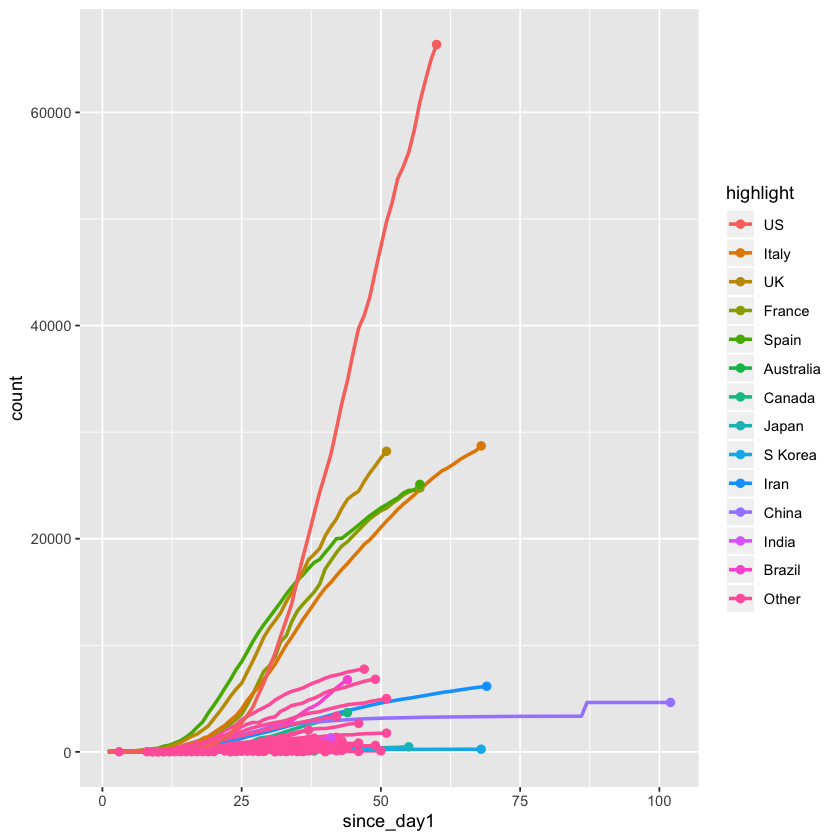

In [18]:
latest = max(data$date)
data_ = data %>% filter(date==latest,count>10)


g1 <-  ggplot() + geom_line(data = data %>%filter(since_day1>0,count>10),
                            aes(x=since_day1,y=count,
                                group=`Country/Region`,
                                colour=highlight),size=1) +
    geom_point(data=data_,aes(x=since_day1,y=count,
                                group=`Country/Region`,
                                colour=highlight),size=2)

g1


## Now, Aesthetics. Very important!!!
We want to try an economist-ish theme this time.
Take some inspiration from [Economist Pattern Library](http://pattern-library.economist.com/color.html) won't hurt!

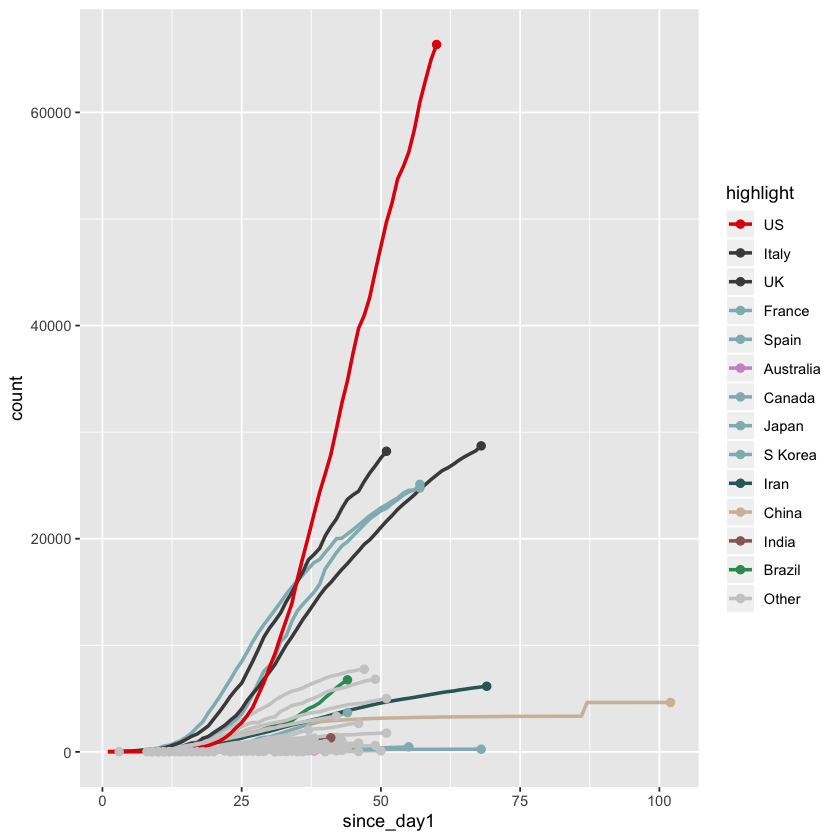

In [19]:
g2 <- g1 + scale_color_manual( values = c("#e3120b", "#4a4a4a", 
                                          "#4a4a4a", "#91b8bd", 
                                          "#91b8bd", "plum3",
                                          "#91b8bd","#91b8bd",
                                          "#91b8bd","#336666", 
                                          "#d1bea8","#996666", 
                                          "#339966", "gray80")) 
g2

Ok, now we need to add a label/text of country name near the end of each line.

So let's first find the position of "end" of each line first.


In [20]:
# extract the latest date from dataset
latest = max(data$date)
# extract a label for each highlighted country
data_ = data %>% filter(`Country/Region` %in% highlighted, date==latest)

Also, because we all know that China's outbreak started way back, we can imagine that it might be streching out of the scale on the x-axis  when we plot the data. So we need to manually adjust their position so they stay within the "safe zone".

In [21]:
data_[4,6] <- data_[4,6] - 23 # adjusting China's text position 
data_[3,6] <- data_[3,6] + 2 # adjusting Chanada's text position
data_

Country/Region,date,count,day1,new,since_day1,highlight
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Australia,2020-05-02,94,0,1,38,Australia
Brazil,2020-05-02,6761,0,1,44,Brazil
Canada,2020-05-02,3684,0,1,46,Canada
China,2020-05-02,4637,0,1,79,China
France,2020-05-02,24763,0,1,57,France
India,2020-05-02,1323,0,1,41,India
Iran,2020-05-02,6156,0,1,69,Iran
Italy,2020-05-02,28710,0,1,68,Italy
Japan,2020-05-02,474,0,1,55,Japan


## Adding textual annotations...

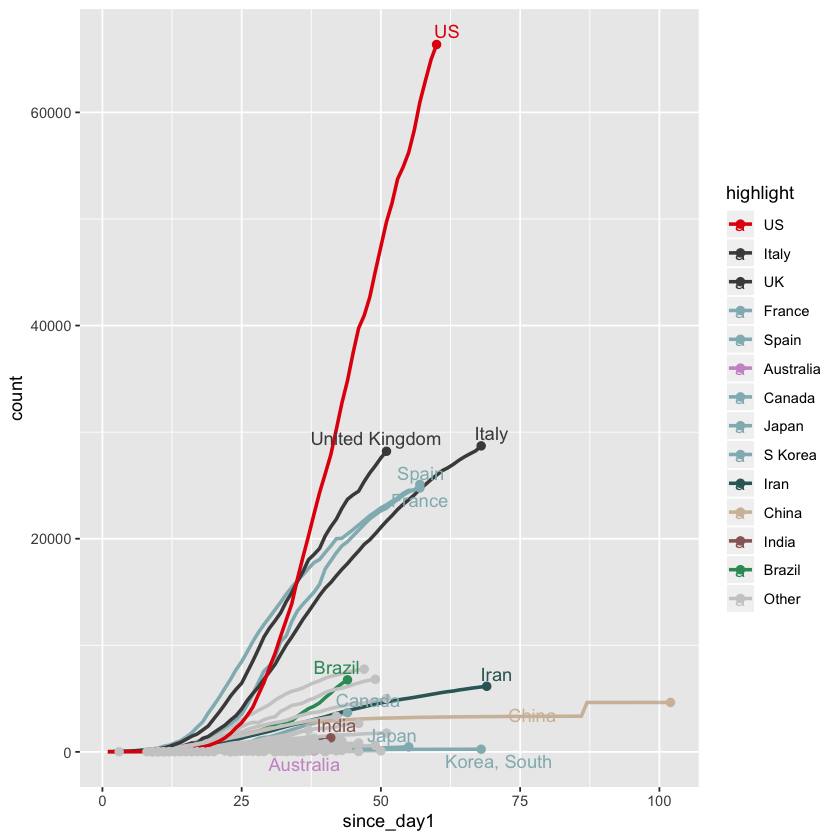

In [22]:
library(ggrepel) 
g3 <- g2 + geom_text_repel(data=data_, 
               aes(x=since_day1,
                   y=count,
                   group=`Country/Region`,
                   colour=highlight,
                   label=`Country/Region`),
                          box.padding = unit(.2, 'lines'))
ggdraw(g3)

# Modifying panel grid.

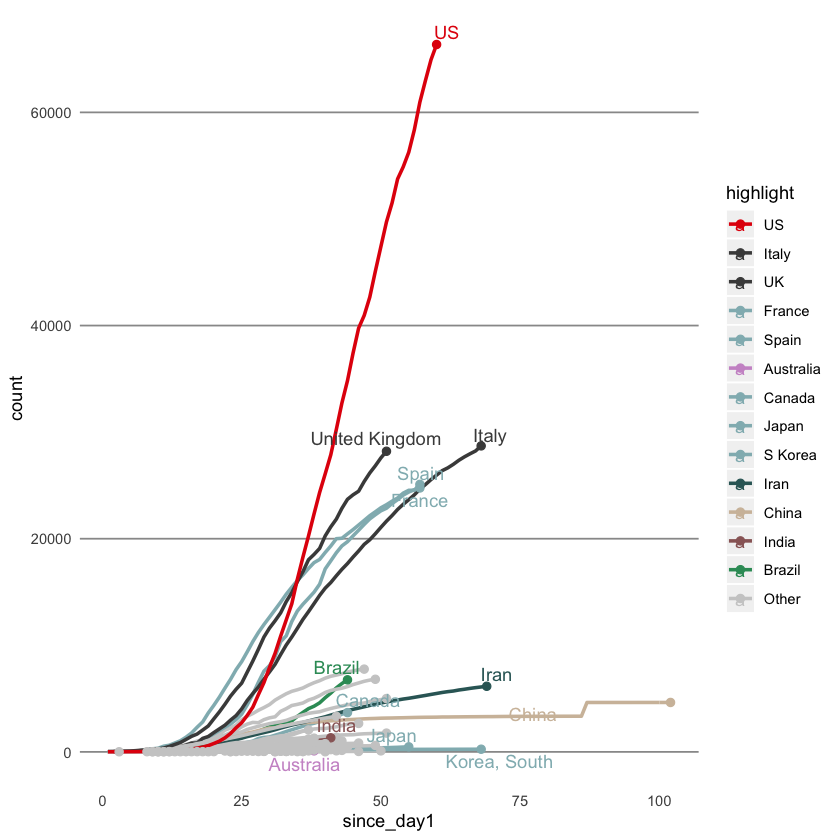

In [23]:
g4 <- g3 + theme(panel.grid.minor = element_blank(), 
        panel.grid.major = element_line(color = "gray60", size = 0.5),
        panel.grid.major.x = element_blank(),
        panel.background = element_blank(),
        line = element_blank())
g4

## Logarithm is gold.
# Repeat, logarithm is gold!


Attaching package: ‘scales’


The following objects are masked from ‘package:formattable’:

    comma, percent, scientific


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Warning message:
“Removed 22 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


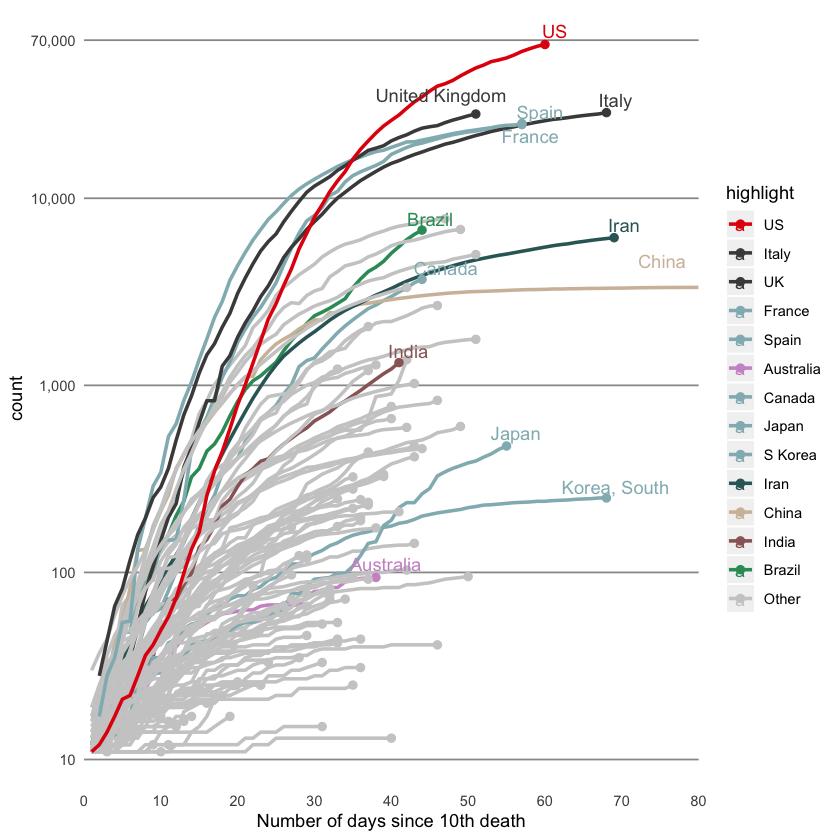

In [24]:
library(scales)
g5 <- g4 + scale_x_continuous(expand = c(0, 0),
                        limits=c(0,80),
                        breaks=seq(0,80,10), 
                        name = "Number of days since 10th death") +
    scale_y_log10(breaks = c(10,100,1000,10000,70000),labels = comma)

ggdraw(g5)

Warning message:
“Removed 22 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 22 rows containing missing values (geom_path).”


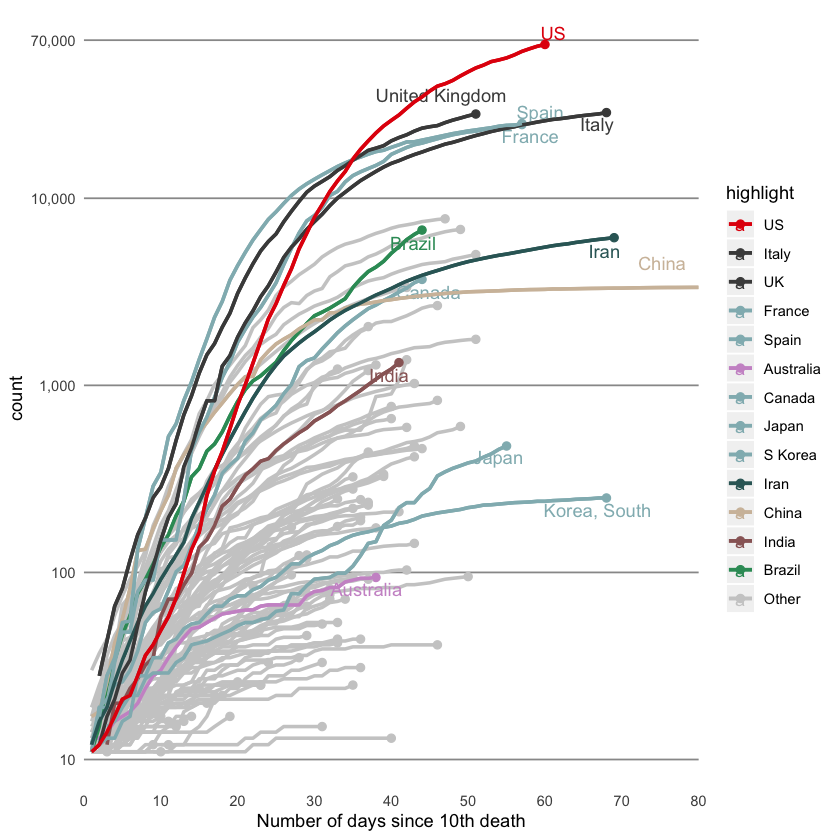

In [25]:
g5 <-  g5 + geom_line(data = data %>%filter(since_day1>0,
                                            count>10, 
                                            `Country/Region`%in% highlighted),
                      aes(x=since_day1,y=count,
                          group=`Country/Region`,
                          colour=highlight),size=1) 
    
g5

# Almost there. 

Putting the finishing touches and adding a layer of `theme_economist()` !!!

Warning message:
“Removed 22 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 22 rows containing missing values (geom_path).”
Warning message:
“Removed 22 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 22 rows containing missing values (geom_path).”


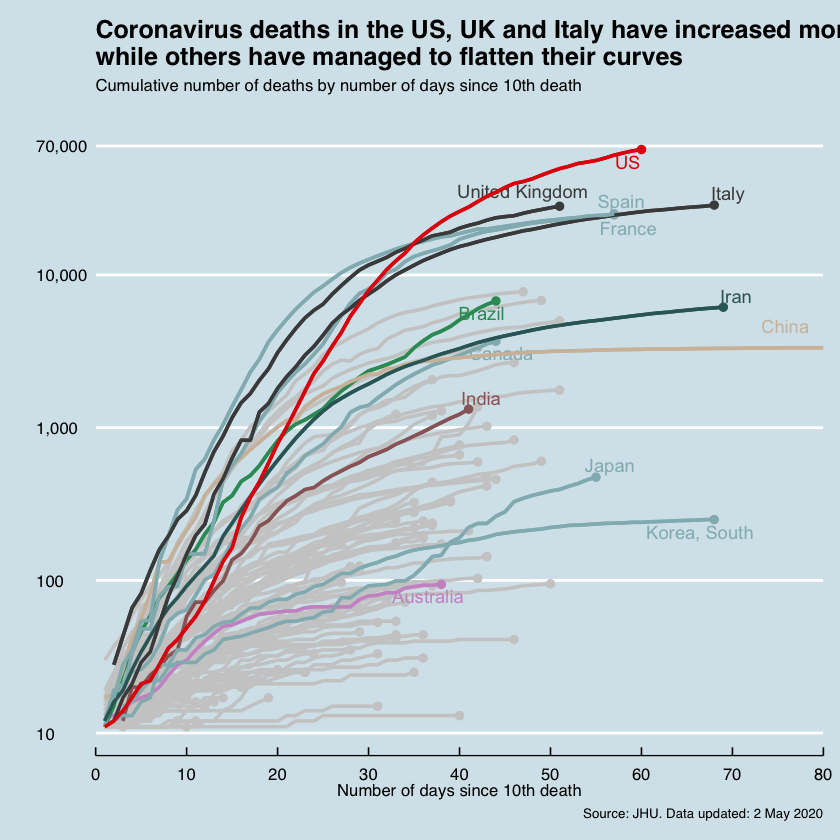

In [26]:
title = "Coronavirus deaths in the US, UK and Italy have increased more rapidly than they did in China,\nwhile others have managed to flatten their curves"
subtitle = "Cumulative number of deaths by number of days since 10th death\n"
g6 <- g5 + labs(title=title,
               subtitle=subtitle,
               caption="Source: JHU. Data updated: 2 May 2020",y="") + theme_economist() +theme(legend.position = "None") 

    
g6
output_label = paste0("economist_style_",Sys.Date(),".png")
ggsave(output_label, width = 12, height = 7, dpi = 120) #export as png


## Here we go.
So, based on this chart we are able to say that:
- US past 60,000 and still sloping upwards
- Japan has passed S Korea
- UK, Spain, France, Italy converging
- Australia still looks promising

#### The exported png file with custom dimension
![ourplot](economist_style_2020-05-03.png)